In [46]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Autores:
- Juan Antonio Sánchez Díaz
- Francisco Javier Gañán Onievas

# 1. Exploración y visualización

El conjunto de datos elegido para realizar el estudio forma parte de spreedsheats, en particular el dataset *Census income*: https://www.apispreadsheets.com/datasets/106. Este conjunto contiene información profesional y personal de personas con el fin de intentar predecir si conseguirá generar unos ingresos mayores a 50.000$ a lo largo del año.

En primer lugar, se realizar un estudio del conjunto de datos para conocer el tamaño del dataseet, que tipo de datos forman el conjunto, números de datos ausentes, etc. Para la lectura se utilizará la librería **Pandas** que permite leer archivos con la extensión .csv como en nuestro caso. 

## Análisis de los atributos y variable respuesta

In [47]:
# Cargamos los datos
df = pd.read_csv("census_income_dataset.csv")
df.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,284582.0,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,160187.0,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,209642.0,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,45781.0,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,159449.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


El conjunto está formado por 48842 instancias con 14 atributos en total y dos clases posibles, $\leq50K\;ó >50K$.
Visualiando algunas instancias del conjunto podemos ver que los atributos están formados por variables tanto numéricas como categóricas. Además, existen algunos valores austentes representados por ?. 

Separamos primero los atributos de la variable respuesta del conjunto.

In [48]:
# Separamos instancias de valor de clasificacion
x_data = df.iloc[:, 0:14]
y_data = df.iloc[:,14:15]

# Separamos los nombres
Names = df.keys()
Names = Names.tolist()
X_names = Names[0:14]
Y_name = Names[-1]

print(X_names)
print(Y_name)

['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
income_level


## Valores ausentes

In [49]:
# Valores ausentes
d = dict()
ind_ausentes = []
X_aus = []

# Contadores    
for name in X_names:
    for i,data in enumerate(x_data[name]):
        if name in d:
            if data == '?':
                d[name] += 1
                if not name in X_aus:
                    X_aus.append(name)
                if not i in ind_ausentes:
                    ind_ausentes.append(i)
        else:
            if data == '?':
                d[name] = 1
                X_aus.append(name)
            else:
                d[name] = 0

print("VARIABLES AUSENTES POR ATRIBUTO")
for name in X_names:
    print(name + ':',d[name])    
    
print('\n',X_aus)

VARIABLES AUSENTES POR ATRIBUTO
age: 0
workclass: 2799
fnlwgt: 0
education: 0
education_num: 0
marital_status: 0
occupation: 2809
relationship: 0
race: 0
sex: 0
capital_gain: 0
capital_loss: 0
hours_per_week: 0
native_country: 857

 ['workclass', 'occupation', 'native_country']


Ahora que conocemos los atributos que poseen datos ausentes podemos trabajar con ellos. En primer lugar, comprobaremos qué tipo de datos son para estudiar qué tecnicas aplicar con ellos.

In [50]:
print(type(x_data['workclass'][0]))
print(type(x_data['occupation'][0]))
print(type(x_data['native_country'][0]))

<class 'str'>
<class 'str'>
<class 'str'>


Podemos ver que todas las variables con ausencias son categóricas, por lo que consideramos dos posibilidades:
* Eliminar las instancias con datos ausentes.
* Utilizar la moda para reemplazar los datos.

Guardaremos los subconjuntos en variables diferentes para su posterior análisis.

In [51]:
suma = 0
for name in X_names:
    suma += d[name]
    
print("Total de datos ausentes",suma)
print("Porcentaje de ausentes",suma/48841*100)

Total de datos ausentes 6465
Porcentaje de ausentes 13.236829712741343


Dada la cantidad de datos que poseemos y el porcentaje al que equivale los datos ausentes podríamos considerar la opción de eliminar este grupo de instancias, por lo que, probaremos a realizar el estudio de predicción eliminandolas y sustituyendo los valores.

# 2. LIMPIEZA Y PREPROCESADO

## Sustitución de valores ausentes

### Sustitución de valores ausentes por moda

Básicamente realizamos un conteo de todas las variables categóricas por atributo y sustituimos los valores ausentes por aquellos que más se repiten (moda). 

In [52]:
def sustituicion_moda(x_data,X_aus):
    x_moda = x_data.copy()
    # Creamos una lista con todos los elementos
    set_cat = dict()
    for name in X_aus:
        caract = set(x_moda[name]) 
        lista = [[name2, len(x_moda[name][x_moda[name] == name2])] for name2 in caract]
        MAX = 0
        for elem in lista:
            if elem[1] > MAX:
                set_cat[name] = elem[0]

    for name in X_aus:
        for i,data in enumerate(x_moda[name]):
            if data == '?':
                x_moda[name][i] = set_cat[name]
    
    return x_moda

In [53]:
x_moda = sustituicion_moda(x_data,X_aus)

# Valores ausentes
d = dict()

# Contadores    
for name in X_aus:
    for i,data in enumerate(x_moda[name]):
        if name in d:
            if data == '?':
                d[name] += 1
        else:
            if data == '?':
                d[name] = 1
            else:
                d[name] = 0

print("VARIABLES AUSENTES POR ATRIBUTO")
for name in X_aus:
    print(name + ':',d[name])  
    
x_moda.head(10)

VARIABLES AUSENTES POR ATRIBUTO
workclass: 0
occupation: 0
native_country: 0


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
5,37,Private,284582.0,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States
6,49,Private,160187.0,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica
7,52,Self-emp-not-inc,209642.0,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States
8,31,Private,45781.0,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States
9,42,Private,159449.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States


### Eliminación de instancias con datos ausentes
Para la eliminación de las intancias utilizaremos la lista de indices de instancias con valores ausentes que creamos anteriormente *ind_ausentes*. Posteriormente, guardaremos el conjunto de datos resultante de eliminar en x_aus.

In [54]:
def sustituicion_elim(x_data,ind_ausentes):
    df_aus = x_data.copy()
    df_aus = df_aus.drop(ind_ausentes)
    x_aus = df_aus.iloc[:, 0:14]
    y_aus = df_aus.iloc[:,14:15]

    # Separamos los nombres
    Names = df.keys()
    Names = Names.tolist()
    X_names_aus = Names[0:14]
    Y_name_aus = Names[14:15]

    return x_aus, y_aus, X_names_aus, Y_name_aus

In [280]:
x_aus,y_aus,X_names_aus,Y_name_aus = sustituicion_elim(df,ind_ausentes)
# Valores ausentes
d = dict()

# Contadores    
for name in X_aus:
    for i,data in enumerate(x_aus[name]):
        if name in d:
            if data == '?':
                d[name] += 1
        else:
            if data == '?':
                d[name] = 1
            else:
                d[name] = 0

print("VARIABLES AUSENTES POR ATRIBUTO")
for name in X_aus:
    print(name + ':',d[name]) 

VARIABLES AUSENTES POR ATRIBUTO
workclass: 0
occupation: 0
native_country: 0


Podemos apreciar que hemos conseguido eliminar todos los datos ausentes del conjunto, y por tanto, podemos seguir trabajando con él. 

Una vez realizado el análisis de las dos posibilidades y comprobado su correcto funcionamiento creamos una función general para la sustitución de valores.

In [55]:
def sustitucion(x_data,tipo):
    d = dict()
    ind_ausentes = []
    X_aus = []

    # Contadores    
    for name in X_names:
        for i,data in enumerate(x_data[name]):
            if name in d:
                if data == '?':
                    d[name] += 1
                    if not name in X_aus:
                        X_aus.append(name)
                    if not i in ind_ausentes:
                        ind_ausentes.append(i)
            else:
                if data == '?':
                    d[name] = 1
                    X_aus.append(name)
                else:
                    d[name] = 0
                    
    if tipo == 'Elimination':
        return sustituicion_elim(x_data,ind_ausentes)
    elif tipo == 'Moda':
        return sustituicion_moda(x_data,X_aus)
    

In [56]:
sustitucion(x_data,'Moda')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419.0,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States
48838,64,Self-emp-inc,321403.0,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,0.0,0.0,40.0,United-States
48839,38,Private,374983.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States
48840,44,Private,83891.0,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States


## Transformación de variables categóricas a numéricas

El siguiente paso es transformar las variables categóricas en variables numéricas. Para ello, observamos los atributos que poseen variables categóricas. Si alguna de ellas son ordinales, podremos enumerarlas de forma directa, si no, utilizaremos la codificación por frecuencia. Para nuestro caso, ninguna clase es ordinal, por lo que realizaremos la codificación por frecuencia. 
Para esta codificación contaremos el número de veces que se repite cada uno de los valores dentro de un atributo y cambiaremos este valor de frecuencia.

### Codificación OneHot

In [21]:
def codificacion_onehot(x_data):
    # Almacenamos las clases categoricas
    cat_class = []
    for name in X_names:
        if type(x_data[name][0])==str:
            cat_class.append(name)

    x_one = x_data.copy()
    for name in cat_class:
        transformed = OneHotEncoder().fit_transform(x_data[[name]])

        x_one = x_one.drop(name,axis=1)
        for i,name2 in enumerate(np.unique(x_data[name])):
            x_one[name2] = transformed.toarray()[:,i]

    # Separamos los nombres
    Names = x_one.keys()
    Names = Names.tolist()
    return x_one, Names

In [11]:
print(codificacion_onehot(x_moda)[0].head(10))

   age    fnlwgt  education_num  capital_gain  capital_loss  hours_per_week  \
0   39   77516.0             13        2174.0           0.0            40.0   
1   50   83311.0             13           0.0           0.0            13.0   
2   38  215646.0              9           0.0           0.0            40.0   
3   53  234721.0              7           0.0           0.0            40.0   
4   28  338409.0             13           0.0           0.0            40.0   
5   37  284582.0             14           0.0           0.0            40.0   
6   49  160187.0              5           0.0           0.0            16.0   
7   52  209642.0              9           0.0           0.0            45.0   
8   31   45781.0             14       14084.0           0.0            50.0   
9   42  159449.0             13        5178.0           0.0            40.0   

   Federal-gov  Local-gov  Never-worked  Private  ...  Portugal  Puerto-Rico  \
0          0.0        0.0           0.0      0.0  

### Codificación por frecuencia

In [57]:
def codificacion_frecuencia(x_data):
    # Almacenamos las clases categoricas
    cat_class = []

    for name in X_names:
        if type(x_data[name][0])==str:
            cat_class.append(name)

    # Creamos una lista con todos los elementos
    set_cat = dict()
    for i,name in enumerate(cat_class):
        set_cat[name] = []
        caract = set(x_data[name])
        for name2 in caract:
            set_cat[name].append([name2, len(x_data[name][x_data[name] == name2])])
            x_data[name][x_data[name] == name2] = len(x_data[name][x_data[name] == name2])
    
    return x_data

In [58]:
x_freq = codificacion_frecuencia(x_moda)

In [59]:
# Variable respuesta categórica a numérica
y_data[y_data == '<=50K'] = 1
y_data[y_data == '>50K'] = 2

y_data = np.array(y_data)
Y = y_data.astype('int')

Podemos apreciar que se han cambiado los valores categóricos por valores numéricos de forma correcta. Con los valores numéricos podemos crear una scatter matrix para poder ver la correlación de Pearson entre los atributos para la preselección de atributos (método de filtrado).

In [60]:
x_data = x_freq

Definimos la función codificación para poder realizar posteriormente un análisis más completo

In [61]:
def codificacion(x_data,y_data,tipo):
    if tipo == 'Frecuencia':
        result = codificacion_frecuencia(x_data)
    elif tipo == 'OneHot':
        result = codificacion_onehot(x_data)
    
    # Variable respuesta categórica a numérica
    y_data[y_data == '<=50K'] = 1
    y_data[y_data == '>50K'] = 2

    y_data = np.array(y_data)
    Y = y_data.astype('int')
    
    return result, Y

# 2. SELECCION DE CARACTERÍSTICAS

Tras haber corregido el conjunto y haberlo preparado para su uso es necesario comprobar si es posible reducir el conjunto de características. Para ello tenemos diferentes posibilidades:
* Métodos de filtrado
* Métodos de envoltura
* Métodos integrados

De este conjunto citado utilizaremos algunos métodos de filtrado y de envoltura para el análisis de los atributos, aunque el número total de atributos ya es suficientemente pequeño.

In [62]:
def seleccion_caracteristicas(X,Y,X_names,tipo):
    if tipo == 'VarianceThreshold':
        sel = VarianceThreshold(threshold=1500000)
        X_new = sel.fit_transform(X)
    elif tipo == 'Chi2':
        X_new = SelectKBest(chi2, k=12).fit_transform(X, Y)
    elif tipo == 'PearsonCorrelation':
        dataframe = pd.DataFrame(X, columns = X_names).drop('relationship',axis=1)
        dataframe = dataframe.drop('sex',axis=1)
        X_new = dataframe.to_numpy()
    elif tipo == 'LDA':
        lda = LDA(n_components=1)
        X_new = lda.fit_transform(X, Y)
    elif tipo == 'RFE':
        model = LogisticRegression().fit(X, Y)
        selector = RFE(modelo, n_features_to_select=5, step=1)
        selector = selector.fit(X, Y)
        X_new = X[:,selector.support_ == True]
        
    return X_new

### Chi Cuadrado $\chi^2$

Para realizar el estudio estadístico $\chi^2$ el conjunto de datos no puede tener valores negativos, por lo que realizaremos la reducción antes de normalizar los valores.

In [94]:
X_new = SelectKBest(chi2, k=12).fit_transform(x_freq, Y)
print(X_new)

[[39 1981 77516.0 ... 2174.0 0.0 43832]
 [50 3862 83311.0 ... 0.0 0.0 43832]
 [38 33906 215646.0 ... 0.0 0.0 43832]
 ...
 [38 33906 374983.0 ... 0.0 0.0 43832]
 [44 33906 83891.0 ... 5455.0 0.0 43832]
 [35 1695 182148.0 ... 0.0 0.0 43832]]


### Eliminación por varianza

In [118]:
sel = VarianceThreshold(threshold=1500000)
X_new = sel.fit_transform(x_freq)
print(X_new.shape)

(48842, 10)


### Latent Dirichlet Allocation (LDA)
El análisis discriminante lineal se usa para encontrar una combinación lineal de características que caracteriza o separa dos o más clases, o niveles, de una variable categórica.

In [ ]:
lda = LDA(n_components=1)
X_new = lda.fit_transform(X, Y)

### Recursive Feature Elimination (RFE)

In [161]:
model = LogisticRegression().fit(X, Y)
selector = RFE(model, n_features_to_select=5, step=1)
selector = selector.fit(X, Y)
print(selector.support_)
print(selector.ranking_)

[ True False False False  True  True False False  True False  True False]
[1 6 5 8 1 1 3 4 1 2 1 7]


### Coeficiente de Correlación de Pearson
Es un método de filtrado. Con este obtendrémos una métrica de la correlación entre atributos dos a dos, por lo que podremos generar un mapa de calor y observar visualmente qué atributos podríamos eliminar.

In [63]:
dataframe = pd.DataFrame(x_freq, columns = X_names)

<AxesSubplot:title={'center':'Coeficiente de Correlación de Pearson entre los atributos'}>

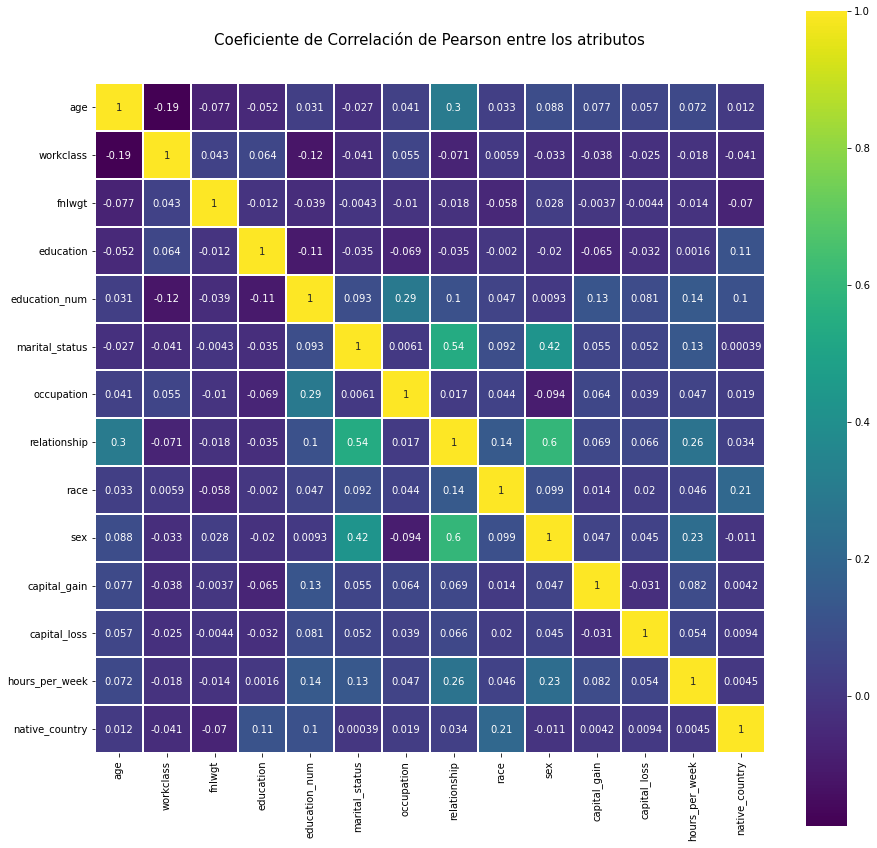

In [98]:
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(dataframe.astype(float).corr(), linewidths=0.1,vmax=1.0, square=True, cmap='viridis', linecolor='white', annot=True)

Vista la previsualización de las correlaciones decidimos eliminar los atributos *relationship* y *sex* que una alta correlación con otros y, tras probarlo en entrenamiento no varía el rendimiento.

In [64]:
dataframe = dataframe.drop('relationship',axis=1)
dataframe = dataframe.drop('sex',axis=1)

In [65]:
X = dataframe.to_numpy()

# Separamos los nombres
Names = dataframe.keys()
Names = Names.tolist()
X_names = Names

print(X)
print(X_names)

[[39 1981 77516.0 ... 0.0 40.0 43832]
 [50 3862 83311.0 ... 0.0 13.0 43832]
 [38 33906 215646.0 ... 0.0 40.0 43832]
 ...
 [38 33906 374983.0 ... 0.0 50.0 43832]
 [44 33906 83891.0 ... 0.0 40.0 43832]
 [35 4494 182148.0 ... 0.0 60.0 43832]]
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'race', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']


## Escalado

El siguiente paso consiste en normalizar los datos por las diferentes escalas que poseen los datos. Para ello podemos utilizar dos técnicas: escalado por máximo y estandarizado. Se probarán los normalizados para comprobar sus valores.

In [66]:
def escalado(data,tipo):
    if tipo == 'StandardScaler':
        z_scaler = preprocessing.StandardScaler()
        X = z_scaler.fit_transform(data)
    elif tipo == 'MinMaxScaler':
        z_scaler = preprocessing.MinMaxScaler() 
        X = z_scaler.fit_transform(data)
    elif tipo == 'Normalize':
        X = preprocessing.normalize(data) 

    #print(pd.DataFrame(X))
    return X

In [67]:
X = escalado(data=X,tipo='StandardScaler')

## PCA (Principal Components Analysis)
Realizamos por tanto la reducción de características aplicando PCA y poder visualizar las clases en el espacio 3d.

In [26]:
def PCA_analisis(x_data, y_data, n, y_angle, z_angle):
    pca = PCA(n_components=n)
    pca.fit(x_data)
    pca_data = pca.transform(x_data)
    
    # Dibujamos un Scree Plot para ver la varianza asociada a cada componente principal
    labels=[]
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    aux = 0
    labels = ['' + str(x) for x in range(1, len(per_var)+1)]
    for k in range(0, len(per_var),2):
        labels[k]=' '

    plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
    plt.ylabel('Porcentaje de varianza (%)')
    plt.xlabel('Componente principal')
    plt.title('Scree Plot')
    plt.show()
    
    # Dibujamos la proyección de las instancias sobre el plano formado por PC1, PC2 y PC3
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    pca_1 = []
    pca_2 = []

    for i in range(len(y_data)):
        if y_data[i] == 1:
            pca_1.append(pca_data[i])
        if y_data[i] == 2:
            pca_2.append(pca_data[i])

    pca_1 = np.array(pca_1)
    pca_2 = np.array(pca_2)

    ax.scatter(pca_1[:,0], pca_1[:,1], pca_1[:,2], c='r', marker='o', label='<=50K')
    ax.scatter(pca_2[:,0], pca_2[:,1], pca_2[:,2], c='b', marker='o', label='>50K')
    
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    ax.legend()
    ax.view_init(y_angle, z_angle)
    plt.show()
    
    return pca_data

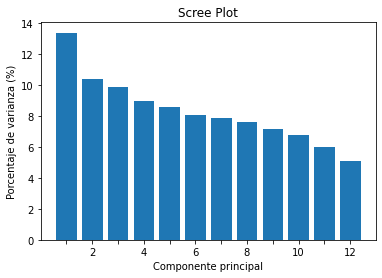

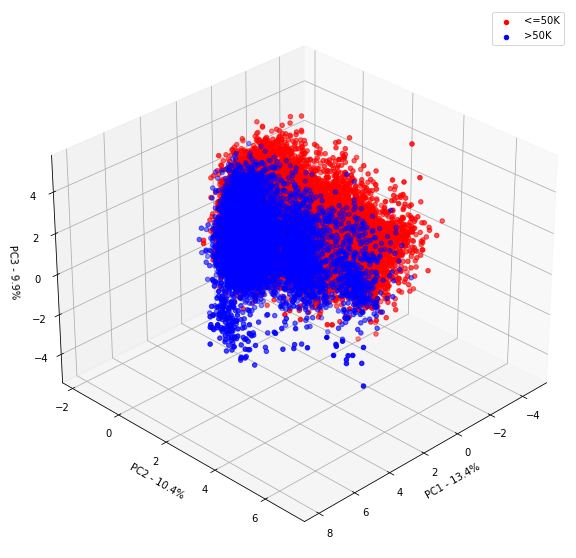

array([[ 1.53489342, -0.28541505,  0.77245367, ...,  0.20382027,
         0.68512291,  0.10134053],
       [ 1.248948  , -0.32184945,  1.09092314, ..., -1.6840005 ,
         0.03397629, -0.40456219],
       [-1.57013797, -1.1467632 ,  0.42042669, ...,  0.84825634,
         0.37598071, -0.94803474],
       ...,
       [ 1.08748989,  0.21673142, -1.71446105, ..., -0.21549979,
        -0.49563187, -0.40965184],
       [ 0.13770624,  1.2580821 ,  0.05492769, ...,  0.86587364,
        -1.3233765 , -0.42707809],
       [ 2.10021367, -0.06565213, -0.06732288, ...,  0.43812335,
         0.51056721,  0.58802209]])

In [24]:
PCA_analisis(X,y_data,12,30,45)

Visualizando el scree plot la varianza se reparte equitativamente en todas las componentes principales del conjunto excepto en la primera y en la última componente, por lo que realemente reducir la dimensionalidad empeorará los resultados a obtener por el modelo de predicción.

Además, podemos ver que las clases están equiespaciadas y divididas en dos grupos que, a priori y en 3 dimensiones, no son linealmente separables, lo que dificultará la tarea de predicción.

## Detección de Outliers (Isolation Forest)
Antes de comenzar con el aprendizaje vamos a realizar un estudio de outliers utilizando Isolation Forest de sklearn.

In [92]:
def outlier_isolation(x_data,y_data, depth):
    out_filter=IsolationForest(n_estimators=100, max_samples='auto', contamination=depth,max_features=1.0)
    out_filter.fit(pd.DataFrame(x_data))
    
    scores = out_filter.predict(pd.DataFrame(x_data))
    anomaly = out_filter.decision_function(pd.DataFrame(x_data))
    print('Numero de outliers:',abs(sum(scores[scores == -1])))
    #scores = scores.tolist()

    x_reduce = x_data[scores == 1]
    y_reduce = y_data[scores == 1]
    
    return x_reduce, y_reduce

In [93]:
x_reduce,y_reduce = outlier_isolation(X,y_data,0.1)

Numero de outliers: 4885


In [34]:
# Ejecutar para eliminar outliers en el aprendizaje
X = x_reduce
y_data = y_reduce

In [94]:
print(x_reduce.shape)
print(y_reduce.shape)

(4885, 12)
(4885, 1)


# 3. APRENDIZAJE DEL MODELO
Para realizar el aprendizaje para la predicción utilizaremos varios modelos. La idea es obtener la probabilidad de pertenencia a una clase u otra, por lo que utilizaremos modelos de regresión logística y SVM con la opción de obtener la probabilidad de predicción.

In [284]:
Y = y_data.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=20,test_size=0.25)
print("Dimensiones de X:",X_train.shape)
print("Dimensiones de Y:",y_train.shape)

Dimensiones de X: (36631, 12)
Dimensiones de Y: (36631, 1)


### Regresión Logística

Comenzamos con el modelo de regresión logística integrado en sklearn.

In [301]:
model = LogisticRegression(solver='saga', random_state=20, C=0.1,
                           penalty='elasticnet', l1_ratio=0.5).fit(X_train, y_train)

In [302]:
print("Rendimiento en el conjunto de entrenamiento:",model.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba:",model.score(X_test,y_test))
print("Rendimiento en el conjunto total:",model.score(X,Y))

Rendimiento en el conjunto de entrenamiento: 0.8392072288498812
Rendimiento en el conjunto de prueba: 0.8366227172221767
Rendimiento en el conjunto total: 0.8385610744850743


In [300]:
param_grid = ParameterGrid(
                {
                    'solver':['saga'], # 'lbfgs', 'liblinear'
                    'C':np.logspace(-3,3,7), 
                    'penalty':['elasticnet'], #,'l2','elasticnet'
                    'l1_ratio':[0,0.01,0.1,0.5,1]
                }
            )

resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo=LogisticRegression(                
                random_state = 20,
                ** params
                )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.score(X_test,y_test))
    print(f"Modelo: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(10)

Modelo: {'C': 0.001, 'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.001, 'l1_ratio': 0.01, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.001, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.001, 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.01, 'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.01, 'l1_ratio': 0.01, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.01, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.01, 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.1, 'l1_ratio': 0, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.1, 'l1_ratio': 0.01, 'penalty': 'elasticnet', 'solver': 'saga'} ✓
Modelo: {'C': 0.1, '

,oob_accuracy,C,l1_ratio,penalty,solver
13,0.836623,0.1,0.50,elasticnet,saga
34,0.836541,1000.0,1.00,elasticnet,saga
25,0.836541,100.0,0.00,elasticnet,saga
21,0.836541,10.0,0.01,elasticnet,saga
22,0.836541,10.0,0.10,elasticnet,saga
14,0.836541,0.1,1.00,elasticnet,saga
23,0.836541,10.0,0.50,elasticnet,saga
24,0.836541,10.0,1.00,elasticnet,saga
26,0.836541,100.0,0.01,elasticnet,saga
27,0.836541,100.0,0.10,elasticnet,saga


## Support Vector Machine (SVM)

In [72]:
model = svm.SVC(kernel='rbf', C=1, probability=True).fit(X_train, y_train)

KeyboardInterrupt: 

In [40]:
print("Rendimiento en el conjunto de entrenamiento:",model.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba:",model.score(X_test,y_test))
#print("Rendimiento en el conjunto total:",model.score(X,Y))

Rendimiento en el conjunto de entrenamiento:  0.8409317471921314
Rendimiento en el conjunto de prueba:  0.8415736310473153
Rendimiento en el conjunto total:  0.8410601307884523


## Cross validation
Una vez que hemos entrenado los modelos correspondientes y analizado su rendimiento podemos realizar un estudio de validación cruzada con el conjunto de datos para comprobar que realmente el resultado obtenido es fiable y que no existe ningún problema al tomar los datos de entrenamiento y test.

In [72]:
scores = cross_val_score(model, X, Y, cv=100)
print(scores)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

[0.80636605 0.81697613 0.80636605 0.83023873 0.83554377 0.84084881
 0.85145889 0.80371353 0.81167109 0.84350133 0.82493369 0.83289125
 0.83289125 0.80901857 0.80636605 0.83819629 0.85941645 0.81962865
 0.82712766 0.85638298 0.78989362 0.84574468 0.81117021 0.85106383
 0.79787234 0.83510638 0.81117021 0.81382979 0.80319149 0.83776596
 0.84308511 0.83776596 0.84042553 0.81382979 0.81382979 0.83244681
 0.85106383 0.84308511 0.81117021 0.85106383 0.80319149 0.81117021
 0.84308511 0.81117021 0.83776596 0.82180851 0.82712766 0.81914894
 0.8856383  0.82180851 0.83510638 0.84840426 0.82180851 0.83510638
 0.82446809 0.85106383 0.84840426 0.84308511 0.82446809 0.82978723
 0.83776596 0.81382979 0.83776596 0.81648936 0.84308511 0.80851064
 0.81117021 0.80851064 0.81648936 0.82978723 0.81117021 0.82180851
 0.85638298 0.80851064 0.82712766 0.85638298 0.84042553 0.83510638
 0.81382979 0.82446809 0.81382979 0.82180851 0.79521277 0.80851064
 0.84840426 0.83244681 0.81648936 0.84308511 0.80585106 0.8244

Realizando el estudio de validación cruzada nos damos cuenta que obtenemos los resultados esperados y similar al rendimiento obtenido de la accuracy para el conjunto de test creado. Esto se debe a que el conjunto es bastante grande y las clases están equilibradas y equiespaciadas, por lo que al dividir el conjunto en k etapas, los resultados son los mismos. 

In [44]:
Y = y_data.astype('int')
X_train, X_test, y_train, y_test = train_test_split(pca_data, Y, 
                                                    random_state=20,test_size=0.20)
print(X_train)
print(y_train)
print("Dimensiones de X:",X_train.shape)
print("Dimensiones de Y:",y_train.shape)

[[-1.34665856  0.13638993  0.19169232]
 [-2.51248836 -1.16614403 -0.34120448]
 [ 1.70718072 -1.7698325  -0.56032706]
 ...
 [-0.8100615   0.92678086 -0.55549454]
 [-3.56931035 -0.562873    2.55496783]
 [ 0.0751603  -1.14675441 -0.66752116]]
[[1]
 [1]
 [2]
 ...
 [1]
 [1]
 [1]]
Dimensiones de X: (36177, 3)
Dimensiones de Y: (36177, 1)


In [74]:
model = LogisticRegression(solver='saga', random_state=20, 
                           penalty='elasticnet', max_iter=100, l1_ratio=0.5).fit(X_train, y_train)
print("Rendimiento en el conjunto de entrenamiento: ",model.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",model.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",model.score(pca_data,Y))

Rendimiento en el conjunto de entrenamiento:  0.8075020040357133
Rendimiento en el conjunto de prueba:  0.8086235489220563
Rendimiento en el conjunto total:  0.8077263278935032


In [47]:
model = svm.SVC(kernel='rbf', C=2).fit(X_train, y_train)
print("Rendimiento en el conjunto de entrenamiento: ",model.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",model.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",model.score(pca_data,Y))

Rendimiento en el conjunto de entrenamiento:  0.8118417779252011
Rendimiento en el conjunto de prueba:  0.8110558319513543
Rendimiento en el conjunto total:  0.8116845783025961


A continuación, obtenemos diferentes métricas de calidad del modelo como precision, recall y f1 a partir de la matriz de confusión.

[[6369  440]
 [1048 1188]]


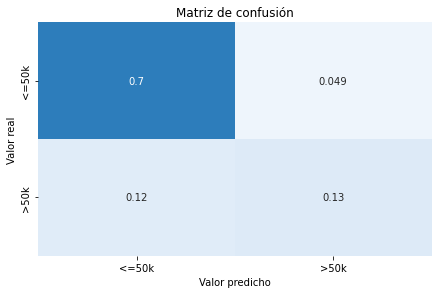

In [168]:
cm = confusion_matrix(y_test, model.predict(X_test))
y_name = ['<=50k','>50k']
print(cm)
# crear marco de datos de pandas Crear un conjunto de datos
dataframe = pd.DataFrame(cm/np.sum(cm), index=y_name, columns=y_name)

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues",vmin=0, vmax=1)
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Valor real"), plt.xlabel("Valor predicho")
plt.show()

In [165]:
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])
f1 = 2* precision*recall / (precision+recall)

print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Precision: 0.7297297297297297
Recall: 0.5313059033989267
F1: 0.6149068322981367


A continuación, realizamos la representación de las curvas PR modificando la umbralización del modelo de regresión logística.

In [166]:
print(y_test)
y_pred = model.predict_proba(X_test)
print(y_pred[0])

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [2]]
[0.71582256 0.28417744]


In [249]:
umbral = 0
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
FPR_list = []
while umbral <= 1:
    proba = model.predict_proba(X_test)
    y_pred = []
    for i in range(0,len(proba)):
        if proba[i][1] > umbral:
            y_pred.append([2])
        else:
            y_pred.append([1])
    #print(y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Umbral',umbral)
    print(cm)
    
    precision = cm[1][1] / (cm[1][1]+cm[0][1])
    recall = cm[1][1] / (cm[1][1]+cm[1][0])
    f1 = 2* precision*recall / (precision+recall)
    accuracy = sum([cm[i,i] for i in range(0,2)]) / np.sum(cm)
    FPR = cm[0][1] / (cm[0][0]+cm[0][1])
    
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('Accuracy:', accuracy,'\n')
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
    FPR_list.append(FPR)
    
    umbral += 0.05

Umbral 0
[[   0 6809]
 [   0 2236]]
Precision: 0.24720840243228304
Recall: 1.0
F1: 0.3964187572023756
Accuracy: 0.24720840243228304 

Umbral 0.05
[[2867 3942]
 [  70 2166]]
Precision: 0.35461689587426326
Recall: 0.9686940966010733
F1: 0.5191754554170661
Accuracy: 0.5564400221116639 

Umbral 0.1
[[3860 2949]
 [ 119 2117]]
Precision: 0.41788393209632846
Recall: 0.9467799642218246
F1: 0.5798411394138592
Accuracy: 0.6608070757324489 

Umbral 0.15000000000000002
[[4461 2348]
 [ 175 2061]]
Precision: 0.46745293717396236
Recall: 0.9217352415026834
F1: 0.6203160270880361
Accuracy: 0.72106135986733 

Umbral 0.2
[[4975 1834]
 [ 281 1955]]
Precision: 0.5159672736869887
Recall: 0.8743291592128801
F1: 0.6489626556016598
Accuracy: 0.7661691542288557 

Umbral 0.25
[[5374 1435]
 [ 396 1840]]
Precision: 0.5618320610687023
Recall: 0.8228980322003577
F1: 0.6677553982943205
Accuracy: 0.7975677169707021 

Umbral 0.3
[[5647 1162]
 [ 533 1703]]
Precision: 0.5944153577661431
Recall: 0.7616279069767442
F1: 0.6

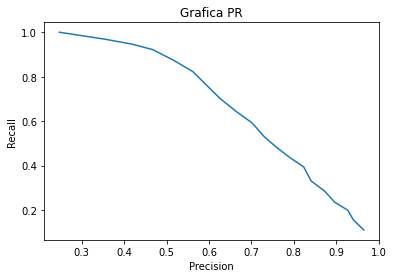

In [250]:
plt.plot(precision_list,recall_list)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Grafica PR')
plt.show()

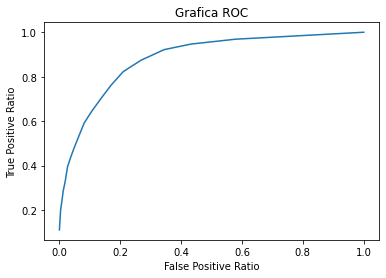

In [252]:
plt.plot(FPR_list,recall_list)
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('Grafica ROC')
plt.show()

## Random Forest
Una vez comprobado el funcionamiento de métodos logísticos para la clasificación comprobaremos el funcionamiento de un clasificador basado en árboles de decisión como es Random Forest.

In [127]:
model_tree = RandomForestClassifier(n_estimators=50,
                 max_features=3,
                 max_depth=15,
                 criterion='entropy')

model_tree.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=3,
                       n_estimators=50)

In [128]:
print("Rendimiento en el conjunto de entrenamiento: ",model_tree.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",model_tree.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",model_tree.score(X,Y))

Rendimiento en el conjunto de entrenamiento:  0.9019749897628122
Rendimiento en el conjunto de prueba:  0.8639953202690845
Rendimiento en el conjunto total:  0.8886818721592072


In [105]:
scores = cross_val_score(model_tree, X, Y, cv=10)
print(scores)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

[0.84954811 0.85911749 0.84502924 0.85406699 0.85459862 0.85885167
 0.84210526 0.84954811 0.84950811 0.85695294]
0.85193 accuracy with a standard deviation of 0.00546


Como hemos podido ver, los resultados obtenidos para este modelo de clasificación son algo mejores que los otros modelos estudiados, por lo que realizaremos un búsqueda de hiperparámetros en busca de la mejor configuración posible. 

Para ello utilizaremos grid search.

## Grid Search

In [179]:
param_grid = ParameterGrid(
                {'n_estimators': [50, 100, 150, 200],
                 'max_features': [3, 5, 7, 9],
                 'max_depth'   : [3, 10, 15, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_

Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'n_estimators': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 3, 'n_estimators': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 3, 'n_estimators': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 3, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 5, 'n_estimators'

,oob_accuracy,criterion,max_depth,max_features,n_estimators
98,0.867452,entropy,15,3,150
35,0.867232,gini,15,3,200
97,0.866885,entropy,15,3,100
99,0.866791,entropy,15,3,200


In [242]:
model_tree = RandomForestClassifier(n_estimators=200,
                 max_features=5,
                 max_depth=12,
                 criterion='entropy')

model_tree.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=5,
                       n_estimators=200)

In [243]:
print("Rendimiento en el conjunto de entrenamiento: ",model_tree.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",model_tree.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",model_tree.score(X,Y))

Rendimiento en el conjunto de entrenamiento:  0.8843355277664031
Rendimiento en el conjunto de prueba:  0.8639368236326411
Rendimiento en el conjunto total:  0.8771958560255518


In [160]:
scores = cross_val_score(model_tree, X, Y, cv=10)
print(scores)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

[0.85793245 0.86816786 0.85872236 0.86773137 0.87305487 0.87387387
 0.86425061 0.86568387 0.86732187 0.86588862]
0.86626 accuracy with a standard deviation of 0.00492


In [161]:
umbral = 0
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
FPR_list = []
while umbral <= 1:
    proba = model_tree.predict_proba(X_test)
    y_pred = []
    for i in range(0,len(proba)):
        if proba[i][1] > umbral:
            y_pred.append([2])
        else:
            y_pred.append([1])
    #print(y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Umbral',umbral)
    print(cm)
    
    precision = cm[1][1] / (cm[1][1]+cm[0][1])
    recall = cm[1][1] / (cm[1][1]+cm[1][0])
    f1 = 2* precision*recall / (precision+recall)
    accuracy = sum([cm[i,i] for i in range(0,2)]) / np.sum(cm)
    FPR = cm[0][1] / (cm[0][0]+cm[0][1])
    
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print('Accuracy:', accuracy,'\n')
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
    FPR_list.append(FPR)
    
    umbral += 0.05

Umbral 0
[[   0 7474]
 [   0 2295]]
Precision: 0.23492680929470774
Recall: 1.0
F1: 0.38047082228116713
Accuracy: 0.23492680929470774 

Umbral 0.05
[[4067 3407]
 [  49 2246]]
Precision: 0.3973111622147532
Recall: 0.9786492374727669
F1: 0.5651736285858078
Accuracy: 0.6462278636503225 

Umbral 0.1
[[4812 2662]
 [ 100 2195]]
Precision: 0.4519250566193123
Recall: 0.9564270152505446
F1: 0.613814317673378
Accuracy: 0.7172689118640598 

Umbral 0.15000000000000002
[[5234 2240]
 [ 148 2147]]
Precision: 0.4894005014816503
Recall: 0.9355119825708061
F1: 0.6426219694702184
Accuracy: 0.7555532807861604 

Umbral 0.2
[[5599 1875]
 [ 232 2063]]
Precision: 0.5238699847638395
Recall: 0.8989106753812636
F1: 0.6619605326488047
Accuracy: 0.7843177397891289 

Umbral 0.25
[[5907 1567]
 [ 310 1985]]
Precision: 0.5588400900900901
Recall: 0.8649237472766884
F1: 0.6789806738498375
Accuracy: 0.8078616030299929 

Umbral 0.3
[[6294 1180]
 [ 429 1866]]
Precision: 0.6126066973079448
Recall: 0.8130718954248366
F1: 0.69

Podemos apreciar tanto con un modelo logístico y un modelo de clasificación que es posible variar el umbral y poder mejorar así las métricas del modelo. Para ambos casos apreciamos que los clasificadores funcionan mejor cuando:

$$umbral > 0.3\;y\;umbral \leq 0.4$$. 

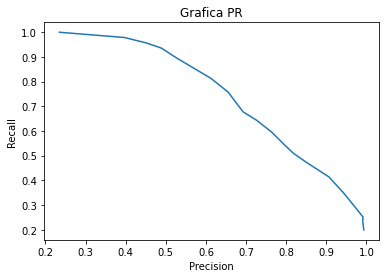

In [162]:
plt.plot(precision_list,recall_list)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Grafica PR')
plt.show()

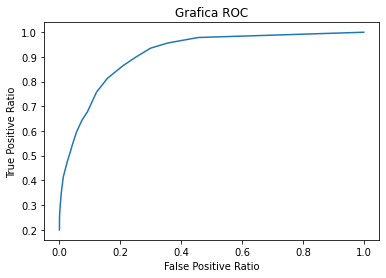

In [163]:
plt.plot(FPR_list,recall_list)
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('Grafica ROC')
plt.show()

La mejor métrica posible se consigue para el umbral 0.35 exactamente.

In [29]:
def umbral_selection(model,X,Y): 
    umbral = 0
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    FPR_list = []
    while umbral <= 1:
        proba = model.predict_proba(X)
        y_pred = []
        for i in range(0,len(proba)):
            if proba[i][1] > umbral:
                y_pred.append([2])
            else:
                y_pred.append([1])
        #print(y_pred)
        cm = confusion_matrix(Y, y_pred)
        print('Umbral',umbral)
        print(cm)

        precision = cm[1][1] / (cm[1][1]+cm[0][1])
        recall = cm[1][1] / (cm[1][1]+cm[1][0])
        f1 = 2* precision*recall / (precision+recall)
        accuracy = sum([cm[i,i] for i in range(0,2)]) / np.sum(cm)
        FPR = cm[0][1] / (cm[0][0]+cm[0][1])

        print('Precision:', precision)
        print('Recall:', recall)
        print('F1:', f1)
        print('Accuracy:', accuracy,'\n')

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        FPR_list.append(FPR)

        umbral += 0.05
        
    plt.plot(precision_list,recall_list)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Grafica PR')
    plt.show()
    
    plt.plot(FPR_list,recall_list)
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title('Grafica ROC')
    plt.show()

Umbral 0
[[    0 13070]
 [    0  4025]]
Precision: 0.23544896168470314
Recall: 1.0
F1: 0.38115530303030304
Accuracy: 0.23544896168470314 

Umbral 0.05
[[5578 7492]
 [ 112 3913]]
Precision: 0.34309513371328365
Recall: 0.9721739130434782
F1: 0.5071937783538562
Accuracy: 0.5551915764843521 

Umbral 0.1
[[7575 5495]
 [ 222 3803]]
Precision: 0.40901269090126907
Recall: 0.9448447204968944
F1: 0.5708924416422727
Accuracy: 0.6655747294530564 

Umbral 0.15000000000000002
[[8701 4369]
 [ 358 3667]]
Precision: 0.4563215530114485
Recall: 0.911055900621118
F1: 0.6080756156205953
Accuracy: 0.7234863995320269 

Umbral 0.2
[[9716 3354]
 [ 553 3472]]
Precision: 0.5086434222092001
Recall: 0.8626086956521739
F1: 0.6399410192608975
Accuracy: 0.7714536414156186 

Umbral 0.25
[[10429  2641]
 [  811  3214]]
Precision: 0.548932536293766
Recall: 0.7985093167701863
F1: 0.6506072874493928
Accuracy: 0.7980696109973676 

Umbral 0.3
[[10974  2096]
 [ 1049  2976]]
Precision: 0.5867507886435331
Recall: 0.739378881987

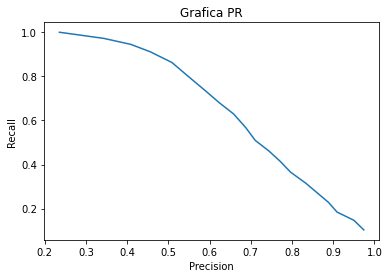

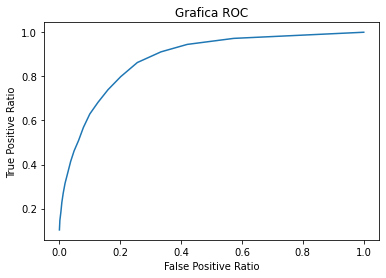

In [131]:
umbral_selection(model_tree,X_test,y_test)

# ANÁLISIS COMPLETO
Una vez hemos comprobado el correcto funcionamiento de todo el proceso completo, concatenaremos los pasos para poder encontrar cuál es la combinación que mejor se comporta y mejores resultados obtiene. Probaremos diferentes combinaciones y mostraremos los resultados.

In [30]:
# Cargamos los datos
df = pd.read_csv("census_income_dataset.csv")

# Separamos instancias de valor de clasificacion
x_data = df.iloc[:, 0:14]
y_data = df.iloc[:,14:15]

# Separamos los nombres
Names = df.keys()
Names = Names.tolist()
X_names = Names[0:14]
Y_name = Names[-1]

In [33]:
x_data = sustitucion(x_data,'Moda')

In [34]:
x_data, y_data = codificacion(x_data,y_data,'Frecuencia')

In [37]:
x_data = seleccion_caracteristicas(x_data,y_data,X_names, 'PearsonCorrelation')

In [40]:
X = escalado(data=x_data,tipo='StandardScaler')

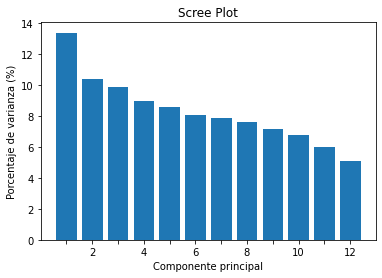

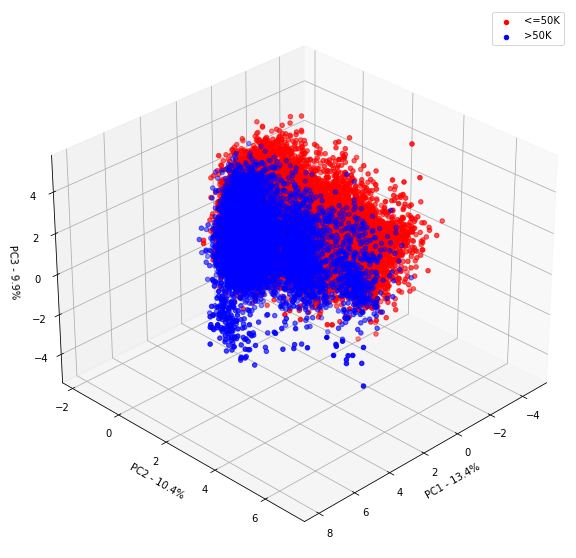

In [152]:
pca_data = PCA_analisis(X, y_data, 12, 30, 45)

In [41]:
X, Y = outlier_isolation(X,0.1)

Numero de outliers: 4885


In [42]:
Y = y_data.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=20,test_size=0.35)

ValueError: Found input variables with inconsistent numbers of samples: [0, 48842]

In [ ]:
model = LogisticRegression(solver='saga', random_state=20, 
                           penalty='elasticnet', max_iter=100, l1_ratio=0.5).fit(X_train, y_train)

In [ ]:
model = svm.SVC(kernel='rbf', C=1, probability=True).fit(X_train, y_train)

In [311]:
model = RandomForestClassifier(n_estimators=200,
                 max_features=3,
                 max_depth=15,
                 criterion='gini').fit(X_train, y_train)

In [312]:
print("Rendimiento en el conjunto de entrenamiento:",model.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba:",model.score(X_test,y_test))
print("Rendimiento en el conjunto total:",model.score(X,Y))

Rendimiento en el conjunto de entrenamiento: 0.9070459446916546
Rendimiento en el conjunto de prueba: 0.8622553435427074
Rendimiento en el conjunto total: 0.8958478358789567


In [ ]:
scores = cross_val_score(model, X, Y, cv=10)
print(scores)
print("%0.5f accuracy with a standard deviation of %0.5f" % (scores.mean(), scores.std()))

In [303]:
param_grid = ParameterGrid(
                {'n_estimators': [50, 100, 150, 200],
                 'max_features': [3, 5, 7, 9, 12],
                 'max_depth'   : [None, 3, 10, 12, 15, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.score(X_test,y_test))
    print(f"Modelo: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Mo

Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 9, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 9, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 12, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 12, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 12, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 15, 'max_features': 12, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion'

Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 3, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 3, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 5, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 7, 'n_estimators': 50} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 7, 'n_estimators': 200} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 9, 'n_estimators

,oob_accuracy,criterion,max_depth,max_features,n_estimators
97,0.863975,gini,15.0,12,100
189,0.863975,entropy,12.0,7,100
204,0.863893,entropy,15.0,5,50
95,0.863811,gini,15.0,9,200


Umbral 0
[[   0 9335]
 [   0 2876]]
Precision: 0.23552534599950864
Recall: 1.0
F1: 0.38125538543116594
Accuracy: 0.23552534599950864 

Umbral 0.05
[[4962 4373]
 [  52 2824]]
Precision: 0.3923857162706683
Recall: 0.9819193324061196
F1: 0.5607068400675072
Accuracy: 0.6376218163950537 

Umbral 0.1
[[5954 3381]
 [ 129 2747]]
Precision: 0.4482702349869452
Recall: 0.9551460361613352
F1: 0.6101732563305198
Accuracy: 0.7125542543608222 

Umbral 0.15000000000000002
[[6528 2807]
 [ 193 2683]]
Precision: 0.48870673952641164
Recall: 0.9328929068150209
F1: 0.6414056896963902
Accuracy: 0.7543198755220702 

Umbral 0.2
[[7004 2331]
 [ 279 2597]]
Precision: 0.5269886363636364
Recall: 0.902990264255911
F1: 0.6655561250640697
Accuracy: 0.7862582917042011 

Umbral 0.25
[[7487 1848]
 [ 386 2490]]
Precision: 0.573997233748271
Recall: 0.8657858136300417
F1: 0.6903243692819517
Accuracy: 0.8170502006387683 

Umbral 0.3
[[7900 1435]
 [ 546 2330]]
Precision: 0.6188579017264276
Recall: 0.8101529902642559
F1: 0.70

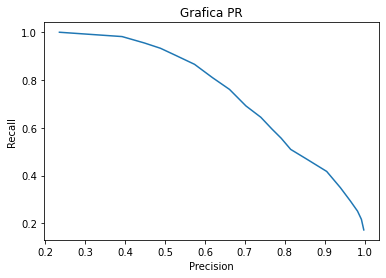

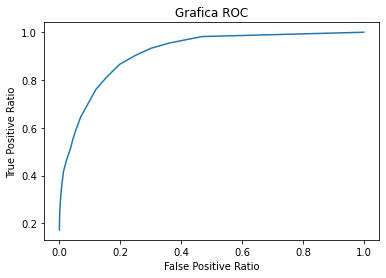

In [313]:
umbral_selection(model,X_test,y_test)

Tras probar varias combinaciones, deducimos que el mejor resultado se obtiene para el clasificador Random Forest reduciendo su umbral de clasificación a 0.35 y aplicando el preprocesado:
* Sustitución por moda
* Codificación por frecuencia
* Selección de características utilizando La correlación de Pearson

No se han eliminado outliers ya que el conjunto total se reducía considerablemente, reduciendo el rendimiento total. Tampoco se han realizado otro de tipo de selección o reducción de características debido a la baja cantidad de atributos del conjunto, por lo que conseguiríamos reducir los tiempos de aprendizaje y predicción pero empeorarían los resultados.

Para conseguir los hiperparámetros del RandomForest se ha realizado un búsqueda intensiva utilizando GridSearch.

Los resultados son:
- Precision: 0.6608544027898866
- Recall: 0.7532919254658386
- F1: 0.7040520143968421
- Accuracy: 0.8508920737057619 

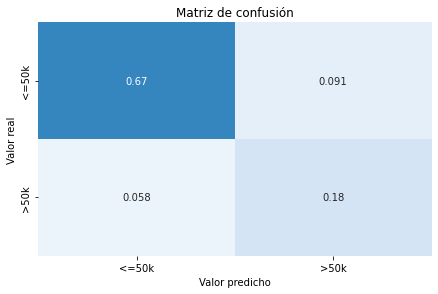

In [188]:
cm = np.array([[11514,1556], [993,3032]])
y_name = ['<=50k','>50k']
# crear marco de datos de pandas Crear un conjunto de datos
dataframe = pd.DataFrame(cm/np.sum(cm), index=y_name, columns=y_name)

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues",vmin=0, vmax=1)
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Valor real"), plt.xlabel("Valor predicho")
plt.show()